In [1]:
import xarray as xr
import datetime
import numpy as np

In [7]:
variable = 'winds'

ds = xr.open_dataset('/home/mduplessis/data/era5/storms/combined_storms_' + variable + '_no_ice.nc')

# ds = ds['str']/3600
# ds = ds['msl'] / 100  # Convert from Pa to hPa
ds = ds[['u10', 'v10']] # Select only the u10 and v10 variables

# --- 1. List to store seasonal means for each year ---
seasonal_means_list = []

# --- 2. Loop through the years ---
start_year = 1981
end_year = 2019 # Loop up to and including 2020

for year in range(start_year, end_year + 1):
    print(f"Processing year: {year}")

    # Define the summer season (Dec 1st of current year to Mar 1st of next year)
    # Using datetime.datetime for clarity, then converting to numpy.datetime64
    start_time_dt = datetime.datetime(year, 12, 1)
    end_time_dt = datetime.datetime(year + 1, 3, 1)

    start_time_np = np.datetime64(start_time_dt)
    end_time_np = np.datetime64(end_time_dt)

    # Boolean indexing for time selection
    # Using >= and < to include Dec 1st and exclude Mar 1st of the next year
    time_idx = (ds.time >= start_time_np) & (ds.time < end_time_np)

    # Select the data for the current winter season
    ds_season = ds.isel(time=time_idx)

    # Check if data was actually selected (important for edge cases or sparse data)
    if ds_season.time.size == 0:
        print(f"  Warning: No data found for the summer season {year}-{year+1}. Skipping.")
        continue

    # Calculate the mean over the time dimension for the season
    # Add a new coordinate 'year' to label this specific seasonal mean
    ds_season_mean = ds_season.mean(dim='time')
    ds_season_mean = ds_season_mean.assign_coords(year=year) # Add year as a coordinate
    ds_season_mean = ds_season_mean.expand_dims('year') # Make year a new dimension for concat

    # Append the resulting mean dataset to the list
    seasonal_means_list.append(ds_season_mean)

# --- 3. Combine all yearly seasonal means into a single dataset ---
if seasonal_means_list: # Check if the list is not empty
    combined_seasonal_means = xr.concat(seasonal_means_list, dim='year')
    print("\nCombined Seasonal Means Dataset:")
    print(combined_seasonal_means)
    print("\nShape of combined dataset (e.g., 'year', 'lat', 'lon'):")
    print(combined_seasonal_means.shape)
else:
    print("\nNo seasonal means were calculated. Check your data and time ranges.")

Processing year: 1981
Processing year: 1982
Processing year: 1983
Processing year: 1984
Processing year: 1985
Processing year: 1986
Processing year: 1987
Processing year: 1988
Processing year: 1989
Processing year: 1990
Processing year: 1991
Processing year: 1992
Processing year: 1993
Processing year: 1994
Processing year: 1995
Processing year: 1996
Processing year: 1997
Processing year: 1998
Processing year: 1999
Processing year: 2000
Processing year: 2001
Processing year: 2002
Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019

Combined Seasonal Means Dataset:
<xarray.Dataset> Size: 1MB
Dimensions:  (year: 39, x: 41, y: 41)
Coordinates:
  * x        (x) int64 328B -1

AttributeError: 'Dataset' object has no attribute 'shape'

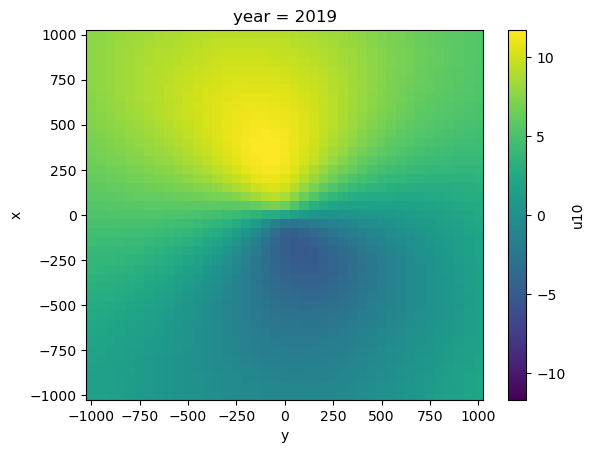

In [9]:
(combined_seasonal_means['u10'].sel(year=2019)).plot(cmap='viridis', add_colorbar=True)

In [11]:
combined_seasonal_means.to_netcdf('/home/mduplessis/data/era5/storms/combined_storms_' + variable + '_seasonal_means.nc')